##### Master Degree in Computer Science and Data Science for Economics

# Classification problems

### Alfio Ferrara

Classification is the problem of assigning a label to an entity, such as a text, based on a set of features. It can be modeled as a function that provides a probability distribution over the target labels given the features, such as:

$$
f : X  \rightarrow \Delta_Y
$$

where $X$ denoted the features and $Y$ the labels. Thus, given a single input $x \in X$, $f(x)$ returns a vector $\mathbf{p}(x) \in \Delta_Y$ such that:

$$
\mathbf{p}(x) = \begin{bmatrix}
p_1(x) \\
p_2(x) \\
\dots \\
p_{\mid Y \mid}(x)
\end{bmatrix}
$$

provided that 

$$
\sum\limits_{i=1}^{\mid Y \mid} p_i(x) = 1,\ ;\ p_i(x) \geq 0 \forall i
$$

### Properties of classification
A classification problem can be:
- A **binary partition**: each input data point can be assigned to one label only among two possible labels
- A **soft binary classification**: each input data point can be assigned to one or two labels among two possible labels
- A **partition**, called **multi-class classification**: each input data point can be assigned to one class only among many
- A **a soft classification**, called **multi-label classification**: each input data point can be assigne to multiple labels among many

## Classify recipes by ingredients

In [1]:
import pymongo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

In [3]:
print(len(data))
data[0]

65212


{'ingredients': ['zucchini',
  'yellow squash',
  'diced tomatoes',
  'onion',
  'garlic',
  'green bell pepper',
  'italian seasoning',
  'water',
  'salt and pepper'],
 'category': 'italian'}

In [4]:
labels

['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']

### Encoding features and labels

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
tokenizer = lambda x: x.split("|")
ingredients_encoder = CountVectorizer(tokenizer=tokenizer, token_pattern=None, binary=True, min_df=20)
labels_encoder = CountVectorizer(tokenizer=tokenizer, token_pattern=None, binary=True)

In [7]:
X = ingredients_encoder.fit_transform(["|".join(x['ingredients']) for x in data]).toarray()
y = labels_encoder.fit_transform([x[label_field] for x in data]).toarray()

In [8]:
print(f"Features: {X.shape}")
print(f"Labels: {y.shape}")

Features: (65212, 2345)
Labels: (65212, 7)


## Check for the dates properties and split in train and test datasets

In [9]:
from sklearn.model_selection import train_test_split

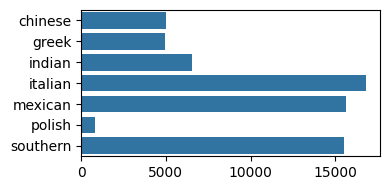

In [10]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.barplot(x=y.sum(axis=0), y=labels_encoder.get_feature_names_out(), ax=ax)
plt.tight_layout()
plt.show()

In [12]:
labels = labels_encoder.get_feature_names_out()
y_true = [labels[int(np.where(a == 1)[0][0])] for a in y]
y_true[:5]

['italian', 'italian', 'italian', 'mexican', 'mexican']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, train_size=.7)

## Classic classifiers

In [14]:
from bornrule import BornClassifier

In [15]:
born = BornClassifier()
born.fit(X_train, y_train)

BornClassifier()

In [16]:
y_pred = born.predict(X_test)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/bornrule/born.py:174: RuntimeWarning: divide by zero encountered in matmul
  u = self._power(self._power(X, self.a) @ self._weights(), 1. / self.a)
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/bornrule/born.py:174: RuntimeWarning: overflow encountered in matmul
  u = self._power(self._power(X, self.a) @ self._weights(), 1. / self.a)
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/bornrule/born.py:174: RuntimeWarning: invalid value encountered in matmul
  u = self._power(self._power(X, self.a) @ self._weights(), 1. / self.a)


In [17]:
y_pred[:5]

array(['mexican', 'southern', 'mexican', 'indian', 'italian'], dtype='<U8')

## Evaluation

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [19]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     chinese       0.69      0.91      0.79      1528
       greek       0.55      0.77      0.64      1454
      indian       0.80      0.86      0.83      1993
     italian       0.86      0.78      0.82      5035
     mexican       0.86      0.84      0.85      4652
      polish       0.14      0.76      0.23       257
    southern       0.83      0.51      0.63      4645

    accuracy                           0.75     19564
   macro avg       0.68      0.78      0.68     19564
weighted avg       0.80      0.75      0.76     19564



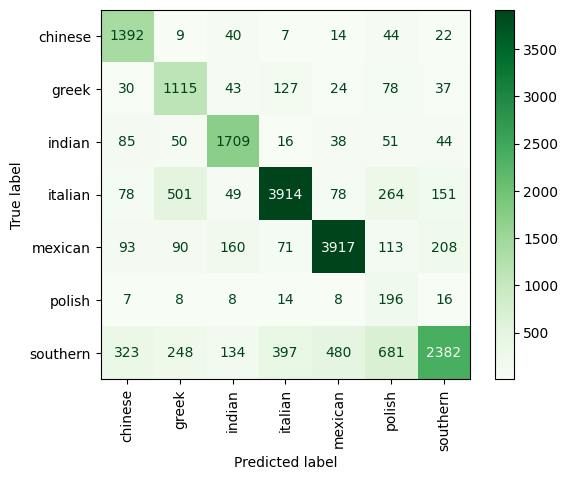

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation='vertical')
plt.show()

## Explainability

### Local explanation

In [21]:
test_recipe = ['potatoes', 'onions', 'salt', 'mushrooms', 'olive oil', 'soy sauce']
vector = ingredients_encoder.transform(["|".join(test_recipe)]).toarray()
print(born.predict(vector)[0])
print(pd.Series(born.predict_proba(vector)[0], index=labels))

chinese
chinese     0.581967
greek       0.091075
indian      0.063301
italian     0.066663
mexican     0.044951
polish      0.079057
southern    0.072987
dtype: float64


In [22]:
local_explain = pd.DataFrame(born.explain(vector), index=ingredients_encoder.get_feature_names_out(), columns=labels)
local_explain.head()

,chinese,greek,indian,italian,mexican,polish,southern
,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1%25 low-fat milk,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10-inch flour tortillas,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2%25 low-fat milk,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6-inch corn tortillas,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
local_explain['chinese'].sort_values(ascending=False).head(10)

soy sauce         0.068921
olive oil         0.004505
potatoes          0.001732
mushrooms         0.001522
onions            0.001006
salt              0.000908
                  0.000000
parsnips          0.000000
parsley           0.000000
parsley flakes    0.000000
Name: chinese, dtype: float64

### Global explanation

In [24]:
global_explain = pd.DataFrame(born.explain(X_test), index=ingredients_encoder.get_feature_names_out(), columns=labels)

In [25]:
global_explain.head()

,chinese,greek,indian,italian,mexican,polish,southern
,0.001662,0.002678,0.005095,0.002425,0.003768,0.003069,0.002087
1%25 low-fat milk,0.001702,0.001638,0.001671,0.002480,0.001547,0.000000,0.001479
10-inch flour tortillas,0.000000,0.000000,0.003481,0.000000,0.011173,0.000000,0.002420
2%25 low-fat milk,0.000000,0.001161,0.003095,0.003069,0.004041,0.003490,0.004188
6-inch corn tortillas,0.000000,0.000000,0.000000,0.001468,0.008210,0.000000,0.002038


In [27]:
global_explain.sort_values(by='italian', ascending=False).head(10)

,chinese,greek,indian,italian,mexican,polish,southern
parmesan cheese,0.089755,0.565247,0.117459,1.320039,0.251857,0.229210,0.462463
olive oil,0.220800,0.779321,0.314857,0.677540,0.405334,0.348512,0.321702
mozzarella cheese,0.052266,0.181222,0.058047,0.484687,0.148770,0.154343,0.132286
extra virgin olive oil,0.073539,0.388860,0.124663,0.414431,0.150212,0.094619,0.131710
fresh basil,0.041590,0.180771,0.053660,0.321107,0.052447,0.037936,0.103130
italian seasoning,0.000000,0.110305,0.018760,0.320659,0.047348,0.000000,0.090157
butter,0.139279,0.276405,0.235650,0.297826,0.210946,0.456428,0.413116
ricotta cheese,0.019730,0.114454,0.040857,0.249568,0.052510,0.039906,0.034145
dried oregano,0.012538,0.331159,0.045286,0.236577,0.183293,0.077122,0.129471
spaghetti sauce,0.000000,0.036843,0.036428,0.220999,0.031589,0.043026,0.045543
